# Announcements

**Assignment 5 -Extended**<br>

**Project 2**<br>
Due: December 1, 2021, class time.

**Practicing makes much difference.** 

**Assignments and Projects**<br>
For assistance in your assignment or project, if you are close to the deadline (e.g., one day earlier), it may be harder to find help.


In [54]:
# Ack: This material was adapted for education purposes from the following sources:
# https://www.kaggle.com/kitakoj18/exploring-wine-descriptions-with-nlp-and-kmeans

## Topic modeling
Topic modeling is an unsupervised ML method used to find inherent structure in documents. It learns
representations of topics in documents which allows grouping of different documents together. We will
use ```Gensim``` library and Latent Dirichlet Allocation (LDA) for this.

LDA’s approach to topic modeling is that it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does is to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

Adapted from https://kleiber.me/blog/2017/07/22/tutorial-lda-wikipedia/

![Topic modeling](https://i.stack.imgur.com/vI8Lc.png)

In [1]:
conda install -c conda-forge wikipedia

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - wikipedia


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wikipedia-1.4.0            |             py_2          13 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          13 KB

The following NEW packages will be INSTALLED:

  wikipedia          conda-forge/noarch::wikipedia-1.4.0-py_2

The following packages will be UPDATED:

  certifi            pkgs/main::certifi-2021.10.8-py37hecd~ --> conda-forge::certifi-2021.10.8-py37hf985489_1
  conda              pkgs/main::conda-4.10.3-py37hecd8cb5_0 --> conda-forge::conda-4.10.3-py37hf985489_3

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.10.26~ --> conda-forge::

In [2]:
import wikipedia, random

def fetch_data(article_names):
    '''Fetching the data from given Wikipedia articles'''
    wikipedia_random_articles = wikipedia.random(2)
    wikipedia_random_articles.extend(article_names)
    wikipedia_random_articles
    print(wikipedia_random_articles)
    
    wikipedia_articles = []
    for wikipedia_article in wikipedia_random_articles:
        wikipedia_articles.append([wikipedia_article, 
                                   wikipedia.page(wikipedia_article).content])
    return wikipedia_articles

In [4]:
import nltk

nltk.download('stopwords')    
from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer # Tokenize the documents.

def clean(article):
    '''Cleaning the article contents and getting the word lemmas'''
    title, document = article
    tokens = RegexpTokenizer(r'\w+').tokenize(document.lower()) # Split into words and Convert to lowercase.
    tokens_clean = [token for token in tokens if token not in stopwords.words('english')]
    
    # Lemmatize the documents.
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_clean]
    
#    tokens_stemmed = [PorterStemmer().stem(token) for token in tokens_clean]

    return (title, tokens_lemmatized)

[nltk_data] Downloading package stopwords to /Users/sagar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import smart_open
smart_open.open = smart_open.smart_open 

from gensim import corpora, models
import gensim

article_names = ['Atlanta', 'Georgia State University', 'Oregon', 'Compiler']
wikipedia_articles = fetch_data(article_names)
wikipedia_articles
wikipedia_articles_clean = list(map(clean, wikipedia_articles))

['Dalit music', 'Salama Abu Hashim', 'Atlanta', 'Georgia State University', 'Oregon', 'Compiler']


In [6]:
article_contents = [article[1] for article in wikipedia_articles_clean]
dictionary = corpora.Dictionary(article_contents)
corpus = [dictionary.doc2bow(article) for article in 
          article_contents] # All except 'Compiler'

In [15]:
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=6, 
                                            id2word = dictionary, 
                                            passes=100)

topic_results = lda_model.print_topics(num_topics=6, num_words=5)
topic_results

[(0,
  '0.000*"reference" + 0.000*"one" + 0.000*"historic" + 0.000*"near" + 0.000*"street"'),
 (1,
  '0.039*"oregon" + 0.023*"state" + 0.009*"portland" + 0.006*"also" + 0.005*"river"'),
 (2,
  '0.016*"atlantic" + 0.013*"georgia" + 0.011*"university" + 0.011*"state" + 0.010*"north"'),
 (3,
  '0.037*"compiler" + 0.030*"language" + 0.012*"code" + 0.011*"program" + 0.010*"end"'),
 (4,
  '0.016*"singer" + 0.011*"folk" + 0.010*"punjabi" + 0.009*"music" + 0.008*"dalit"'),
 (5,
  '0.002*"hashim" + 0.002*"abu" + 0.002*"salama" + 0.002*"jaffa" + 0.002*"village"')]

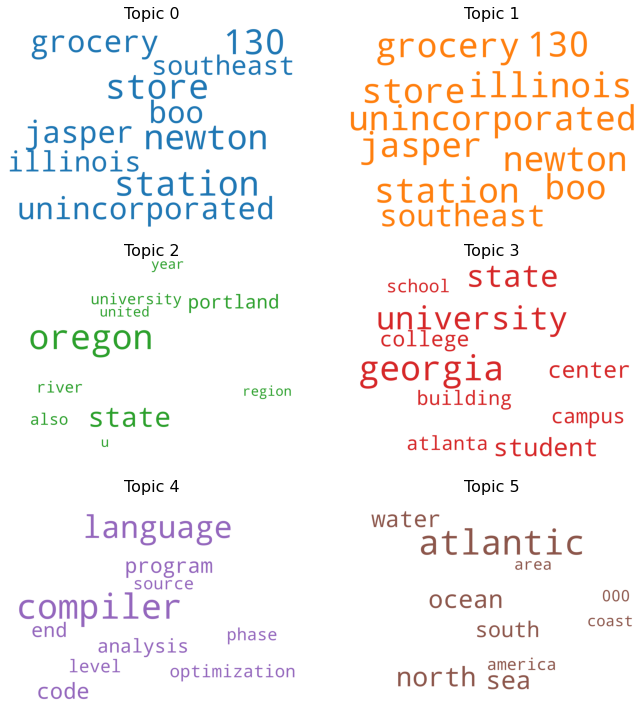

In [52]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [8]:
print(list(lda_model[[dictionary.doc2bow(article_contents[-1])]]))

[[(5, 0.99976546)]]


## Unsupervised NLP

## import libraries

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

## load data

In [11]:
winedf = pd.read_csv('winemag-data-130k-v2.csv.zip')
winedf.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [12]:
winedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [14]:
winedf[winedf['description'].duplicated(keep = False)].sort_values('description').head(8)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
67614,67614,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
46540,46540,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
119702,119702,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
72181,72181,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
73731,73731,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
100745,100745,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
73730,73730,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe
100744,100744,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe


In [6]:
winedf = winedf.drop_duplicates('description')

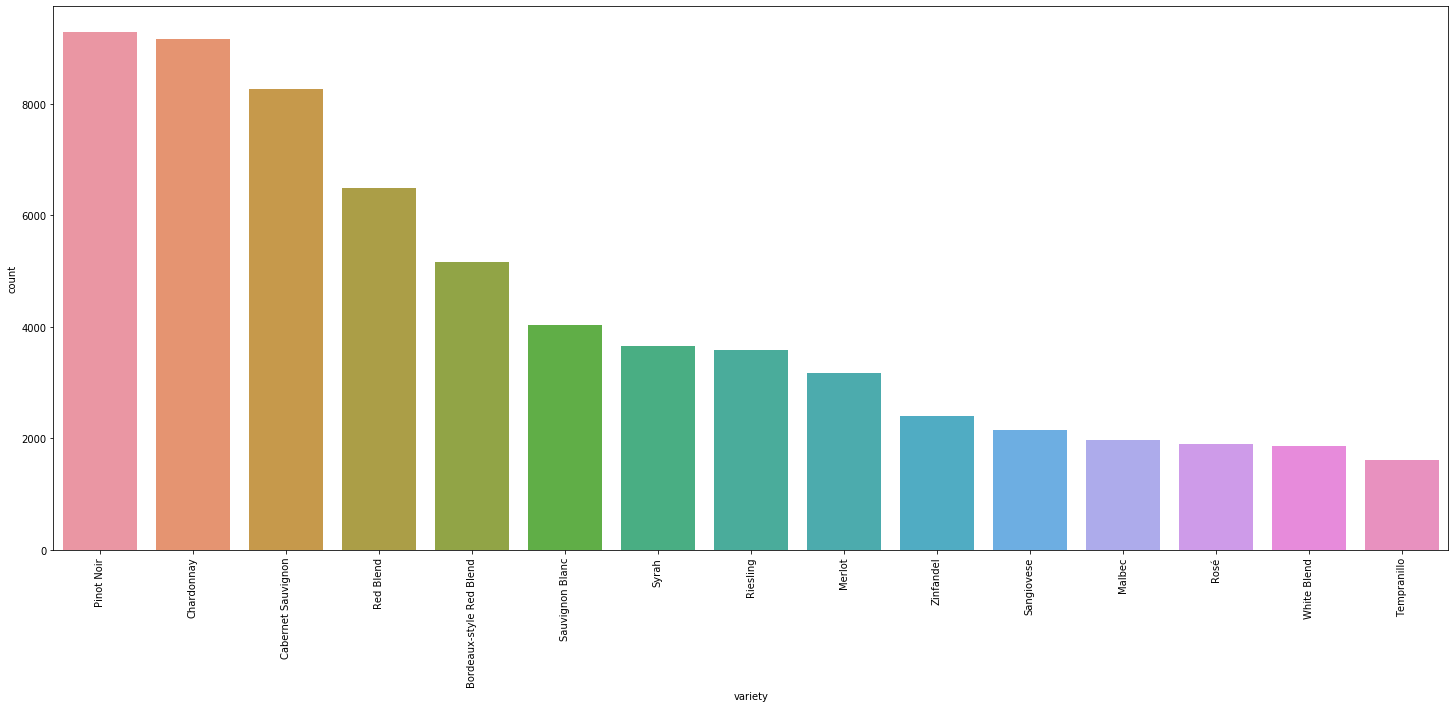

In [7]:
variety_df = winedf.groupby('variety').filter(lambda x: len(x) > 1500)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [8]:
variety_df['variety'].unique()

array(['Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Tempranillo', 'Malbec', 'Rosé', 'Syrah',
       'Sangiovese', 'Red Blend', 'Riesling', 'White Blend', 'Zinfandel',
       'Bordeaux-style Red Blend', 'Merlot'], dtype=object)

## Data Pre-processing

In [9]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_df['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)

In [10]:
word_features = vectorizer.get_feature_names()
word_features[550:575]

['aboard',
 'abondante',
 'abound',
 'abounding',
 'abounds',
 'abouriou',
 'abracadabra',
 'abrasive',
 'abrasiveness',
 'abreu',
 'abroad',
 'abrupt',
 'abruptly',
 'abruzzi',
 'abruzzo',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbs',
 'abstberg',
 'absurd',
 'abtsberg']

In [11]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [12]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
word_features2[:50]

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


["'s",
 "a'",
 "a'plenti",
 'aa',
 'aah',
 'aand',
 'aaron',
 'abacela',
 'abad',
 'abadia',
 'abandon',
 'abarbanel',
 'abbacchio',
 'abbay',
 'abbey',
 'abbinar',
 'abboccato',
 'abbott',
 'abbrevi',
 'abbuoto',
 'abc',
 'abeill',
 'abeja',
 'abernathi',
 'aberr',
 'abetina',
 'abey',
 'abil',
 'abl',
 'abli',
 'abnorm',
 'aboard',
 'abondant',
 'abound',
 'abouriou',
 'abov',
 'abracadabra',
 'abras',
 'abreu',
 'abroad',
 'abrupt',
 'abruzzi',
 'abruzzo',
 'absenc',
 'absent',
 'absolut',
 'absorb',
 'abstberg',
 'absurd',
 'abtsberg']

In [13]:
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [18]:
X3

<64736x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1272544 stored elements in Compressed Sparse Row format>

## K-Means Clustering

In [14]:
kmeans = KMeans(n_clusters = 15, n_init = 5, n_jobs = -1)
kmeans.fit(X3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=5, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [15]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : blackberri, currant, dri, tannin, flavor, rich, cherri, oak, drink, wine
1 : pinot, noir, cherri, cola, silki, flavor, raspberri, dri, acid, drink
2 : red, fruit, cherri, wine, flavor, berri, spice, aroma, palat, finish
3 : sampl, barrel, wine, tannin, fruit, ripe, wood, structur, juici, veri
4 : appl, green, flavor, pear, finish, palat, citrus, wine, acid, aroma
5 : black, cherri, palat, aroma, tannin, fruit, plum, dark, finish, pepper
6 : chardonnay, pineappl, butter, oak, toast, flavor, vanilla, acid, rich, pear
7 : sweet, cherri, flavor, soft, simpl, tast, raspberri, like, candi, wine
8 : berri, aroma, finish, plum, flavor, palat, herbal, feel, nose, fruit
9 : wine, age, fruit, wood, structur, tannin, year, rich, ripe, firm
10 : cabernet, sauvignon, blend, merlot, franc, petit, verdot, wine, syrah, cherri
11 : wine, fruit, flavor, cherri, finish, tannin, spice, oak, vineyard, aroma
12 : wine, fresh, acid, fruiti, fruit, attract, light, drink, crisp, soft
13 : blanc, sauvignon, 

In [16]:
variety_df['cluster'] = kmeans.labels_

In [19]:
variety_df['cluster']

0          2
2         14
3          5
8         11
9         11
          ..
149630     7
149632    14
149637    11
149638     4
149639    14
Name: cluster, Length: 64736, dtype: int32

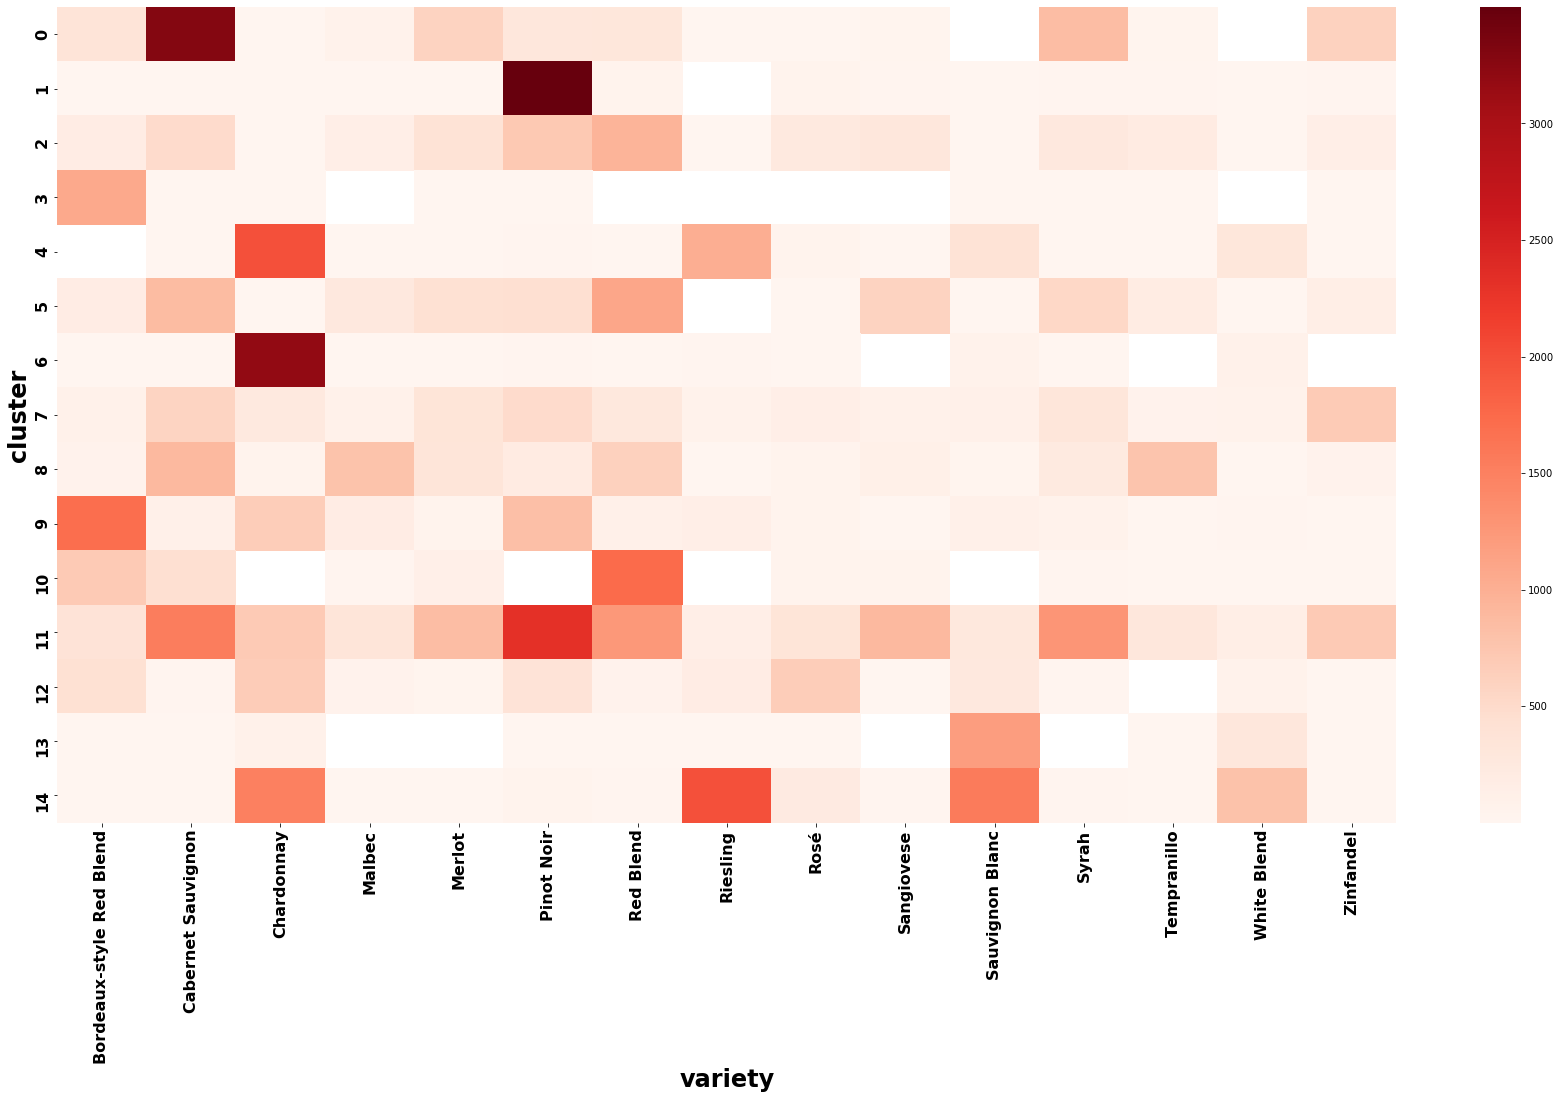

In [17]:
clusters = variety_df.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

## Resources

**Books**

Here are a few helpful references:

- [**Speech and Language Processing**](https://web.stanford.edu/~jurafsky/slp3/), by Dan Jurafsky and James H. Martin (free PDF)

- [**Introduction to Information Retrieval**](https://nlp.stanford.edu/IR-book/html/htmledition/irbook.html) by By Christopher D. Manning, Prabhakar Raghavan, and Hinrich Schütze (free online)

- [**Natural Language Processing with PyTorch**](https://learning.oreilly.com/library/view/natural-language-processing/9781491978221/) by Brian McMahan and Delip Rao (need to purchase or have O'Reilly Safari account) 

**Blogs**

Good NLP-related blogs:
- [Sebastian Ruder](http://ruder.io/)
- [Joyce Xu](https://medium.com/@joycex99)
- [Jay Alammar](https://jalammar.github.io/)
- [Stephen Merity](https://smerity.com/articles/articles.html)
- [Rachael Tatman](https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213)

## More Resources

- More on NLP https://monkeylearn.com/blog/definitive-guide-natural-language-processing/
- A very comprehensive list of resources by Penn https://www.seas.upenn.edu/~romap/nlp-resources.html
- Peter Norvig's spell corrector http://norvig.com/spell-correct.html
- Applications and datasets https://machinelearningmastery.com/datasets-natural-language-processing/
- More datasets https://gengo.ai/datasets/the-best-25-datasets-for-natural-language-processing/
- https://towardsdatascience.com/text-analytics-topic-modelling-on-music-genres-song-lyrics-deb82c86caa2
- Collection of tutorials https://medium.com/machine-learning-in-practice/over-200-of-the-best-machine-learning-nlp-and-python-tutorials-2018-edition-dd8cf53cb7dc
- Text classification https://textminingonline.com/dive-into-nltk-part-vii-a-preliminary-study-on-text-classification
